Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([mobilenet_v2_100_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5)) from TensorFlow Hub, how does it perform compared to our other models?

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Dowload the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-10-11 19:06:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   187MB/s    in 0.9s    

2023-10-11 19:06:29 (187 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
# How many images in each folder?
import os

# Walk through 1- percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`")

There are 2 directories and 0 images in `10_food_classes_10_percent`
There are 10 directories and 0 images in `10_food_classes_10_percent/test`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/pizza`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/grilled_salmon`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/sushi`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/ramen`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/chicken_curry`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/hamburger`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/steak`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/fried_rice`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/ice_cream`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/chicken_wings

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [6]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [7]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [8]:
# Importing dependecies
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):

  # Download the pretrained model and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing MobileNetV2 TensorFlow Hub feature Extraction model

In [13]:
# Create mobile model
mobile_model = create_model(mobilenet_url,
                            num_classes=train_data_10_percent.num_classes)

In [14]:
# Compile the model
mobile_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [15]:
mobile_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              2257984   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [16]:
train_data_10_percent.num_classes

10

In [17]:
# Let's fit our MobileNet model to the data (10 percent of 10 classes)
mobile_history = mobile_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="mobilenetv2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20231011-191504
Epoch 1/5
24/24 [==============================] - 22s 458ms/step - loss: 2.0575 - accuracy: 0.3027 - val_loss: 1.3727 - val_accuracy: 0.5876
Epoch 2/5
24/24 [==============================] - 12s 503ms/step - loss: 1.0958 - accuracy: 0.6960 - val_loss: 0.9099 - val_accuracy: 0.7340
Epoch 3/5
24/24 [==============================] - 10s 413ms/step - loss: 0.7653 - accuracy: 0.7907 - val_loss: 0.7533 - val_accuracy: 0.7756
Epoch 4/5
24/24 [==============================] - 9s 405ms/step - loss: 0.6039 - accuracy: 0.8467 - val_loss: 0.6900 - val_accuracy: 0.7928
Epoch 5/5
24/24 [==============================] - 9s 406ms/step - loss: 0.4994 - accuracy: 0.8707 - val_loss: 0.6377 - val_accuracy: 0.8020


In [18]:
# Let's create a function to plot our loss curves..
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs= range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

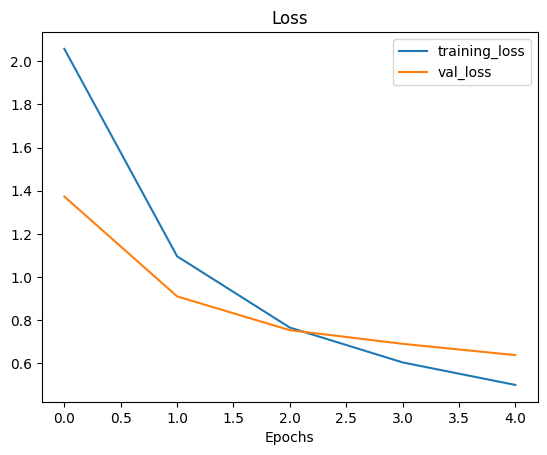

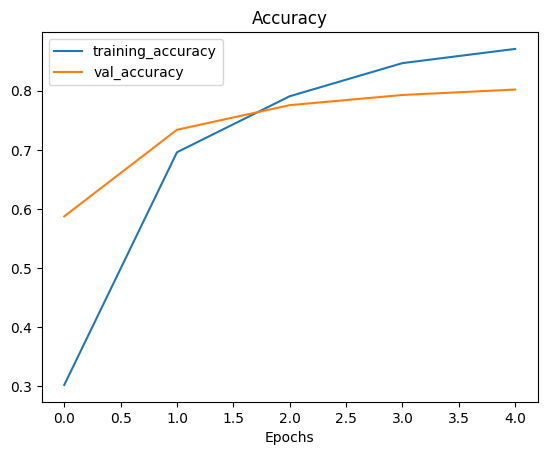

In [19]:
plot_loss_curves(mobile_history)

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "MobileNetV2" \
  --description "Seeing the performance of MobileNet"\
  --one_shot